## Result analysis of the ranking based tests. TO DO the implementation of the tests random and no random tests from Kim, 1987


### 1. Import libraries

In [10]:
%reset
import numpy as np
import operator as op
from functools import reduce
import time
import pandas as pd
import matplotlib.pyplot as plt 
import random as rnd
from scipy import stats

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### 2. Cutting functions: Class definition

In [11]:
# the class allow to define both cutting functions and permutations, in order to execute a bisection method or randomly
class CPfunctions():
    def __init__(self, 
                 Ndata, cut = None, perm = None):
        self.N = Ndata   # size of the data
    def permutation(self, random = False):
        """
        Define the permutation index for a bisection method, or in a random fashion if random is True
        """
        N = self.N
        K = np.arange(1,N+1)
        new_K = []
        if random:
            np.random.shuffle(K)
            new_K = K
        else:
            k_first = list(K)
            k_first.sort()
            K_List = [k_first]
            K_marker = [0]  # index that says if the corresponding K_List has been partitioned or not

            for i in range(N):
                # choose list to divide
                for j in range(len(K_List)):
                    if K_marker[j] == 0 and len(K_List[j]) >= 1:
                        length_K = len(K_List[j])
                        # choose position of new_K in the list
                        K_position = (length_K+1)//2 -1   # the middle (even) or the first integer greater than the middle (odd)
                        new_K.append(K_List[j][K_position])
                        # split the existing array            
                        K_List.append(K_List[j][:K_position])
                        K_List.append(K_List[j][K_position+1:])
                        K_marker[j] = 1
                        K_marker.append(0)
                        K_marker.append(0)
                        # now add elements to H_new
                        break
                        
        self.perm = np.array(new_K)
        
    def cutting(self, random = False):
        """
        Define the cutting functions for a bisection method, or in a random fashion if random is True
        """
        N = self.N
        H = np.random.randint(0, 2, N)
        K = self.perm
        new_H = H
        if not random:            
            H_counter = []   # counter to asign values of H
            h = 0
            while sum(H_counter) <= len(new_H):
                H_counter.append(2**h)
                h = h+1

            H_value = [0]*len(H_counter)    # values of H to asign
            for i in range(len(H_value)):
                if i%2 == 1:
                    H_value[i] = 1

            # for each element in K, asign the corresponding element in H

            for i in range(N):
                for m in range(len(H_value)):
                    if i+1 <= sum(H_counter[:m+1]):
                        new_H[K[i]-1] = H_value[m]
                        break
                        
        self.cut = np.array(new_H)


### 3. Blocks: Class definition

### Let's define a class to work with the blocks

In [12]:
class block():
    def __init__(self, 
                 vertices = None, 
                 elements = None, 
                 stats = None, 
                 parent = None, 
                 leftChild = None, 
                 rightChild = None, 
                 prefChild = None):
        self.vertices = vertices   # array with 2 bidimensional elements, corresponding to the vertices of the block
                                   # vertices must be ordered starting from the left bottom vertix and finishing with the
                                   # right top vertix
                                   # the array must have two rows and two columns (bidimensional case)
        self.elements = elements   # array with the points that belong to the block. Each row contains an element and each
                                   # column is a dimension (in this case, bidimensional)
        self.stats = np.sort(stats) # array with index of blocks
        self.parent = parent       # parent of the block
        self.leftChild = leftChild
        self.rightChild = rightChild
        self.prefChild = prefChild
    
    def plot(self, color = 'C0', lw = 1, size = 12, print_num = True):
        plt.plot(self.vertices[:,0], np.ones(2)*self.vertices[0,1], color = color, lw = lw)
        plt.plot(np.ones(2)*self.vertices[1,0], self.vertices[:,1], color = color, lw = lw)
        plt.plot(self.vertices[:,0], np.ones(2)*self.vertices[1,1], color = color, lw = lw)
        plt.plot(np.ones(2)*self.vertices[0,0], self.vertices[:,1], color = color, lw = lw)
        xplot = (self.vertices[0,0]+self.vertices[1,0])/2
        yplot = (self.vertices[0,1]+self.vertices[1,1])/2
        if self.stats.size == 1 and print_num:
            plt.text(xplot, yplot, str(self.stats[0]), fontsize = size)

        
    def split(self, axis, korder):
        """
        This method split a Block and creates two child blocks, making the partition on the korder th statistic
        axis: indicates wheter it is along the X axis (vertical, 0) or the Y axis (horizontal, 1)
        korder: is the order statistic to make the partition
        """
        # select the dimension to sort
        Xele = self.elements[:,axis]
        # select the kth order statistic
        Xorder = np.sort(Xele)
        minStat = min(self.stats)
        korder = korder - minStat
        xstat = Xorder[korder]
        # divide the stats
        statsL = self.stats[:korder+1]
        statsR = self.stats[korder+1:]
        # create the elements and vertices of each block
        Relements = np.empty((0, 2))
        Lelements = np.empty((0, 2))
        
        # add elements to vertices and elements for each case
        if axis == 0:
            Lvertices = np.array([self.vertices[0,:], [xstat, self.vertices[1,1]]])
            Rvertices = np.array([[xstat, self.vertices[0,1]], self.vertices[1,:]])
            # now we move on the elements of the parent block and select wich ones go to the left and right child
            for l in range(self.elements.shape[0]):
                if Xele[l] < xstat:
                    Lelements = np.append(Lelements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                elif Xele[l] > xstat:
                    Relements = np.append(Relements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                else:
                    Pchild = [self.elements[l,:]]  # chosen kth order 
        elif axis == 1:
            Lvertices = np.array([self.vertices[0,:], [self.vertices[1,0], xstat]])
            Rvertices = np.array([[self.vertices[0,0], xstat],self.vertices[1,:]])
            # now we move on the elements of the parent block and select wich ones go to the left and right child
            for l in range(self.elements.shape[0]):
                if Xele[l] < xstat:
                    Lelements = np.append(Lelements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                elif Xele[l] > xstat:
                    Relements = np.append(Relements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                else:
                    Pchild = [self.elements[l,:]]   # chosen kth order 
                
        # create the childs of the block
        Rchild = block(vertices = Rvertices, elements = Relements, stats = statsR, parent = self)  
        # right side or up side (the greaters elements)
        Lchild = block(vertices = Lvertices, elements = Lelements, stats = statsL, parent = self)   
        # left side or down side (the smaller elements)
        
        # asociate the childs to the parten
        self.rightChild = Rchild
        self.leftChild = Lchild
        self.prefChild = Pchild
        # return the place where the partition was made
        return xstat
    
    def belong(self, x):
        nx = x.shape[0]
        out = True
        for i in range(nx):
            out = out and self.vertices[0,i] < x[i] <= self.vertices[1,i]
        return out
        
        

In [13]:
# other functions to calculate distributions and order blocks

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom

def prob_M_null(s, N, M):
    """
    Calculate probabilitie that exactly s of the ma's are 0, under H0
    N is the size of data that defined the blocks (therefore, s in {0,...,N})
    M is the size of new data that is being compared
    """    
    if N >= M-1 and s < N-M+1:
        return 0
    else:
        num = ncr(N+1, s)*ncr(M-1, N-s)
        den = ncr(M+N, N)
        return num/den
    
    return num/den

def order_blocks(Blocks):
    """
    order the final blocks, so in the list of blocks they will be on the order corresponding to their statistics
    """
    Blocks_Order = []
    N_Blocks = len(Blocks)
    Assigned_Blocks = 0
    i = 0
    while Assigned_Blocks < N_Blocks:
        if Blocks[int(i%N_Blocks)].stats[0] == Assigned_Blocks+1:
            Blocks_Order.extend([Blocks[i%N_Blocks]])
            Assigned_Blocks = Assigned_Blocks + 1
        i = i + 1  # search in another block
    return Blocks_Order

def counting_blocks(Blocks, data):
    """
    counts the number of elementos from data belonging to each block of the list Blocks
    """
    data_copy = np.copy(data)   # copy Y to eliminate the elements already assigned to a block
    Ma = np.zeros(len(Blocks))  # 

    # calculate the values of m_{alpha}
    for k in range(len(Blocks)):
        i = 0
        while i < data_copy.shape[0]:   # count the elements that belong to the k-th block
            if Blocks[k].belong(data_copy[i,:]):
                Ma[k] = Ma[k] + 1
                data_copy = np.delete(data_copy, i, axis = 0)  # eliminate to make a shorter search
                i = i - 1
            i = i + 1
    return Ma

def rank_by_blocks(blocks, countings):
    """
    vectors of ranking for each sample according to the constructed blocks
    """
    rank_flag = True
    rank_correction = 1
    ranks_1 = []
    ranks_2 = []
    for i in range(len(blocks)):
        if countings[i] == 0 & rank_flag:
            ranks_1.append(rank_correction)
            rank_correction += 1
            rank_flag = False
        elif countings[i] != 0 & rank_flag:
            ranks_2.extend(np.arange(rank_correction,rank_correction + countings[i]))
            rank_correction += countings[i]
            ranks_1.append(rank_correction)
            rank_correction += 1
            rank_flag = False
        elif countings[i] == 0:
            ranks_1.append(rank_correction)
            rank_correction += 1
        elif countings[i] != 0:
            ranks_2.extend(np.arange(rank_correction,rank_correction + countings[i]))
            rank_correction += countings[i]
            ranks_1.append(rank_correction)
            rank_correction += 1
    ranks_1.remove(ranks_1[-1])
    return ranks_1, ranks_2


### 4. Summary of the report data 

In [110]:
X = np.array([[4.91, 2.16], [6.05, 5.54], [3.48, 1.35], [8.09, 0.18], [2.53, 3.49],
              [1.62, 2.46], [8.37, 2.29], [3.17, 6.27], [6.02, 4.51], [8.50, 4.65],
              [4.21, 5.93], [0.15, 5.99], [9.31, 3.77], [4.10, 0.45], [5.83, 2.42],
              [6.00, 0.27], [3.30, 8.93], [4.38, 7.81], [4.93, 6.64], [1.22, 1.54]])
Y = np.array([[13.90, 2.13], [7.71, 6.89], [9.67, 6.20], [7.56, 0.90], [10.39, 2.43],
              [13.47, 0.45], [14.55, 0.01], [7.46, 0.181], [11.25, 1.08], [13.00, 2.37],
              [6.33, 4.44], [11.86, 0.83], [7.42, 2.31], [9.15, 3.94], [12.73, 6.12],
              [6.58, 3.04], [7.34, 3.69], [8.12, 2.59], [7.79, 3.68], [5.65, 2.40]])
#Y = 1.001*X
print(np.concatenate((X,Y)))


[[4.910e+00 2.160e+00]
 [6.050e+00 5.540e+00]
 [3.480e+00 1.350e+00]
 [8.090e+00 1.800e-01]
 [2.530e+00 3.490e+00]
 [1.620e+00 2.460e+00]
 [8.370e+00 2.290e+00]
 [3.170e+00 6.270e+00]
 [6.020e+00 4.510e+00]
 [8.500e+00 4.650e+00]
 [4.210e+00 5.930e+00]
 [1.500e-01 5.990e+00]
 [9.310e+00 3.770e+00]
 [4.100e+00 4.500e-01]
 [5.830e+00 2.420e+00]
 [6.000e+00 2.700e-01]
 [3.300e+00 8.930e+00]
 [4.380e+00 7.810e+00]
 [4.930e+00 6.640e+00]
 [1.220e+00 1.540e+00]
 [1.390e+01 2.130e+00]
 [7.710e+00 6.890e+00]
 [9.670e+00 6.200e+00]
 [7.560e+00 9.000e-01]
 [1.039e+01 2.430e+00]
 [1.347e+01 4.500e-01]
 [1.455e+01 1.000e-02]
 [7.460e+00 1.810e-01]
 [1.125e+01 1.080e+00]
 [1.300e+01 2.370e+00]
 [6.330e+00 4.440e+00]
 [1.186e+01 8.300e-01]
 [7.420e+00 2.310e+00]
 [9.150e+00 3.940e+00]
 [1.273e+01 6.120e+00]
 [6.580e+00 3.040e+00]
 [7.340e+00 3.690e+00]
 [8.120e+00 2.590e+00]
 [7.790e+00 3.680e+00]
 [5.650e+00 2.400e+00]]


### 5. Blocks from data X Y

In [111]:
sample_1 = X
sample_2 = Y
all_sample = np.concatenate((X,Y), axis = 0)
#all_sample = Y
[N, cols] = all_sample.shape
N_x = sample_1.shape[0]
print(N,cols, N_x)


Lists = CPfunctions(N)
Lists.permutation()
Lists.cutting()
K = Lists.perm
H = Lists.cut
print(K)
print(H[K-1])

max_box = np.max([sample_1,sample_2])+10
min_box = np.min([sample_1,sample_2])-10
print(max_box, min_box)
First_Block = block(vertices = np.array([[min_box,min_box],[max_box,max_box]]),
                    elements = all_sample, 
                    stats = range(1,N+2))
Blocks_List = [First_Block]

for i in range(N):
    # search the last block that has the K[i] stat
    for j in range(len(Blocks_List)):
        #print(i, K[i], j)
        if K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None:
            Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
            Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])
            break
Blocks_Final = []
for j in range(len(Blocks_List)):
    if Blocks_List[j].leftChild == None:
        Blocks_Final.extend([Blocks_List[j]])
print(len(Blocks_Final))
for j in range(len(Blocks_Final)):
    print(Blocks_Final[j].stats)
# test if both data samples come from the same distribution
# order the blocks and count their elements


40 2 20
[20 10 30  5 15 25 35  2  7 12 17 22 27 32 38  1  3  6  8 11 13 16 18 21
 23 26 28 31 33 36 39  4  9 14 19 24 29 34 37 40]
[0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1]
24.55 -9.99
41
[1]
[2]
[3]
[6]
[7]
[8]
[11]
[12]
[13]
[16]
[17]
[18]
[21]
[22]
[23]
[26]
[27]
[28]
[31]
[32]
[33]
[36]
[39]
[4]
[5]
[9]
[10]
[14]
[15]
[19]
[20]
[24]
[25]
[29]
[30]
[34]
[35]
[37]
[38]
[40]
[41]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
[]
[[ 4.1  -9.99]
 [ 4.91  1.35]]
True


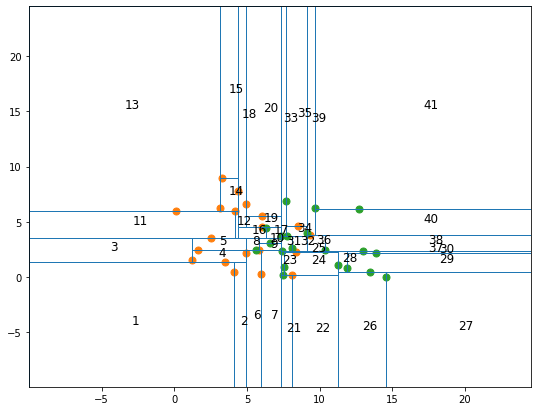

In [112]:
Blocks_Order = order_blocks(Blocks_Final)
Ma = np.zeros((len(Blocks_Order)))
ranks_pop1, ranks_pop2 = rank_by_blocks(blocks = Blocks_Order, countings = Ma)
print(ranks_pop1)
print(ranks_pop2)
print(Blocks_Order[1].vertices)

# plot blocks and samples
fig = plt.figure(figsize=(9,7))
plt.plot(X[:,0], X[:,1], 'o', color = 'C1', ms = 7)
plt.plot(Y[:,0], Y[:,1], 'o', color = 'C2', ms = 7)

plt.xlim(min_box,max_box)
plt.ylim(min_box,max_box)
for j in range(len(Blocks_Order)):
    Blocks_Order[j].plot(print_num = True)

print(Blocks_Order[0].belong(np.array([3.48, 1.35])))

In [113]:
ranks_X = []
ranks_Y = []

for x_index in range(X.shape[0]):
    found = False   # we have not found the block for X[index_x]
    j = 0
    while (not found and j < len(Blocks_Order)):
        if Blocks_Order[j].belong(X[x_index]):
            ranks_X.append(Blocks_Order[j].stats[0])
            found = True
        else:
            j += 1

for y_index in range(Y.shape[0]):
    found = False   # we have not found the block for X[index_x]
    j = 0
    while (not found and j < len(Blocks_Order))
        if Blocks_Order[j].belong(Y[y_index]):
            ranks_Y.append(Blocks_Order[j].stats[0])
            found = True
        else:
            j += 1

print(ranks_X)
print(ranks_Y)
ks_test = stats.ks_2samp(ranks_X, ranks_Y)
mw_test = stats.mannwhitneyu(ranks_X,ranks_Y, alternative = 'two-sided')    
print(ks_test)
print(mw_test)

[4, 19, 1, 21, 5, 4, 24, 13, 16, 34, 11, 11, 36, 1, 8, 6, 14, 14, 18, 3]
[29, 33, 39, 23, 36, 26, 26, 21, 24, 37, 16, 28, 23, 34, 40, 9, 17, 31, 31, 6]
Ks_2sampResult(statistic=0.6000000000000001, pvalue=0.0007252860301701226)
MannwhitneyuResult(statistic=66.0, pvalue=0.00030221861498440963)


In [114]:
Blocks_Order = order_blocks(Blocks_Final)
MaX = counting_blocks(Blocks_Order, sample_1)
MaY = counting_blocks(Blocks_Order, sample_2)
#MaX = np.zeros((len(Blocks_Order)))
ranks_popX1, ranks_popX2 = rank_by_blocks(blocks = Blocks_Order, countings = MaX)
ranks_popY1, ranks_popY2 = rank_by_blocks(blocks = Blocks_Order, countings = MaY)
#print(ranks_popX1)    
print(ranks_popX2)
#print(ranks_popY1)
print(ranks_popY2)

ks_test = stats.ks_2samp(ranks_popX2, ranks_popY2)
mw_test = stats.mannwhitneyu(ranks_popX2,ranks_popY2, alternative = 'two-sided')    
print(ks_test)
print(mw_test)

[1.0, 2.0, 5.0, 7.0, 8.0, 10.0, 12.0, 15.0, 19.0, 20.0, 23.0, 25.0, 26.0, 29.0, 32.0, 34.0, 37.0, 41.0, 52.0, 55.0]
[6.0, 10.0, 18.0, 20.0, 25.0, 28.0, 29.0, 31.0, 34.0, 35.0, 38.0, 40.0, 43.0, 44.0, 47.0, 49.0, 52.0, 54.0, 57.0, 59.0]
Ks_2sampResult(statistic=0.4, pvalue=0.059142334165034526)
MannwhitneyuResult(statistic=107.0, pvalue=0.012320202749369336)


### 6. Blocks from data Y

In [0]:
sample_1 = Y
sample_2 = X
all_sample = Y
[N, cols] = all_sample.shape
df_sample = pd.DataFrame(all_sample)
df_sample['idx'] = range(len(df_sample))
df_sample['name'] = 'pop_1'
df_sample = df_sample.set_index(['name', 'idx'])
max_box = np.max([sample_1,sample_2])+10
min_box = np.min([sample_1,sample_2])-10
First_Block = Block(sample_data = df_sample,
                    vertices = np.array([[min_box,min_box],[max_box,max_box]]),
                    elements = all_sample, 
                    stats = range(1,N+2))
Blocks_List = [First_Block]
for i in range(N):
    # search the last block that has the K[i] stat
    for j in range(len(Blocks_List)):
        if (K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None):
            Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
            Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])            
            break
Blocks_Final = []
for j in range(len(Blocks_List)):
    if Blocks_List[j].leftChild == None:
        Blocks_Final.extend([Blocks_List[j]])
# test if both data samples come from the same distribution
# order the blocks and count their elements
Blocks_Order = order_blocks(Blocks_Final)
Ma = counting_blocks(Blocks_Order, sample_2)
ranks_pop1, ranks_pop2 = rank_by_blocks(blocks = Blocks_Order, countings = Ma)
print(ranks_pop1)    
print(ranks_pop2)

ks_test = stats.ks_2samp(ranks_pop1, ranks_pop2)
mw_test = stats.mannwhitneyu(ranks_pop1,ranks_pop2)    
print(ks_test) 
print(mw_test) 

[6.0, 7.0, 10.0, 12.0, 13.0, 15.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 35.0, 37.0, 38.0, 39.0, 40.0]
[1.0, 2.0, 3.0, 4.0, 5.0, 8.0, 9.0, 11.0, 14.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 33.0, 34.0, 36.0]
Ks_2sampResult(statistic=0.55, pvalue=0.00396729438660086)
MannwhitneyuResult(statistic=106.0, pvalue=0.005716414654220047)


### Considering de cases used by Mauricio from Kim's paper
### 7. Location case

In [0]:
# first data from Kim: Location
meanX = 0.7*np.array([1,1])
covX = 1*np.array([[1,0],[0,1]])
meanY = np.array([0,0])
covY = 1*np.array([[1,0],[0,1]])
N = 32
M = 32

Xmin = min(meanX[0]-4*covX[0,0], meanY[0]-4*covY[0,0])
Xmax = max(meanX[0]+4*covX[0,0], meanY[0]+4*covY[0,0])
Ymin = min(meanX[1]-4*covX[1,1], meanY[1]-4*covY[1,1])
Ymax = max(meanX[1]+4*covX[1,1], meanY[1]+4*covY[1,1])


# define cutting functions and permutation order, blocks from data X
Lists = CPfunctions(N)
Lists.permutation()
Lists.cutting()
K = Lists.perm
H = Lists.cut

### Excecution of Nrep repetitions of the test, generating diferent samples and using blocks from data X

In [0]:
Nrep = 5   # number of repetitions
counter = 0   # counts the number of rejections of H0

start = time.time()

for repetition in range(Nrep):
    #generate X data
    X = np.random.multivariate_normal(meanX, covX, N)
    # generate Y data
    Y = np.random.multivariate_normal(meanY, covY, M)
    # configuration
    sample_1 = X
    sample_2 = Y
    all_sample = X
    [N, cols] = all_sample.shape
    df_sample = pd.DataFrame(all_sample)
    df_sample['idx'] = range(len(df_sample))
    df_sample['name'] = 'pop_1'
    df_sample = df_sample.set_index(['name', 'idx'])
    # create list with blocks
    First_Block = Block(sample_data = df_sample,
                        vertices = np.array([[Xmin,Ymin],[Xmax,Ymax]]),
                        elements = all_sample, 
                        stats = range(1,N+2))
    Blocks_List = [First_Block]
    for i in range(N):
        # search the last block that has the K[i] stat
        for j in range(len(Blocks_List)):
            if (K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None):
                Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
                Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])            
                break
    Blocks_Final = []
    for j in range(len(Blocks_List)):
        if Blocks_List[j].leftChild == None:
            Blocks_Final.extend([Blocks_List[j]])
    # test if both data samples come from the same distribution
    # order the blocks and count their elements
    Blocks_Order = order_blocks(Blocks_Final)
    Ma = counting_blocks(Blocks_Order, sample_2)
    ranks_pop1, ranks_pop2 = rank_by_blocks(blocks = Blocks_Order, countings = Ma)
    ks_test = stats.ks_2samp(ranks_pop1, ranks_pop2)
    mw_test = stats.mannwhitneyu(ranks_pop1,ranks_pop2)    
    print(ks_test) 
    print(mw_test) 

end = time.time()
print(end-start)

Ks_2sampResult(statistic=0.4375, pvalue=0.003930635540499007)
MannwhitneyuResult(statistic=234.0, pvalue=9.725762465288967e-05)
Ks_2sampResult(statistic=0.5625, pvalue=5.222642099890917e-05)
MannwhitneyuResult(statistic=219.0, pvalue=4.292696657077734e-05)
Ks_2sampResult(statistic=0.34375, pvalue=0.04486227643337436)
MannwhitneyuResult(statistic=304.0, pvalue=0.0026670372721594947)
Ks_2sampResult(statistic=0.5625, pvalue=5.222642099890917e-05)
MannwhitneyuResult(statistic=232.0, pvalue=8.740395720111071e-05)
Ks_2sampResult(statistic=0.375, pvalue=0.021411615091346068)
MannwhitneyuResult(statistic=299.0, pvalue=0.002163590575705298)
0.22963237762451172


### Excecution of Nrep repetitions of the test, generating diferent samples and using blocks from data Y

In [0]:
Nrep = 5   # number of repetitions
counter = 0   # counts the number of rejections of H0
for repetition in range(Nrep):
    #generate X data
    X = np.random.multivariate_normal(meanX, covX, N)
    # generate Y data
    Y = np.random.multivariate_normal(meanY, covY, M)
    # configuration
    sample_1 = Y
    sample_2 = X
    all_sample = Y
    [N, cols] = all_sample.shape
    df_sample = pd.DataFrame(all_sample)
    df_sample['idx'] = range(len(df_sample))
    df_sample['name'] = 'pop_1'
    df_sample = df_sample.set_index(['name', 'idx'])
    # create list with blocks
    First_Block = Block(sample_data = df_sample,
                        vertices = np.array([[Xmin,Ymin],[Xmax,Ymax]]),
                        elements = all_sample, 
                        stats = range(1,N+2))
    Blocks_List = [First_Block]
    for i in range(N):
        # search the last block that has the K[i] stat
        for j in range(len(Blocks_List)):
            if (K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None):
                Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
                Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])            
                break
    Blocks_Final = []
    for j in range(len(Blocks_List)):
        if Blocks_List[j].leftChild == None:
            Blocks_Final.extend([Blocks_List[j]])
    # test if both data samples come from the same distribution
    # order the blocks and count their elements
    Blocks_Order = order_blocks(Blocks_Final)
    Ma = counting_blocks(Blocks_Order, sample_2)
    ranks_pop1, ranks_pop2 = rank_by_blocks(blocks = Blocks_Order, countings = Ma)
    ks_test = stats.ks_2samp(ranks_pop1, ranks_pop2)
    mw_test = stats.mannwhitneyu(ranks_pop1,ranks_pop2)    
    print(ks_test) 
    print(mw_test) 


Ks_2sampResult(statistic=0.53125, pvalue=0.0001740880699963639)
MannwhitneyuResult(statistic=256.0, pvalue=0.0003010819994525373)
Ks_2sampResult(statistic=0.46875, pvalue=0.0015053497817310642)
MannwhitneyuResult(statistic=265.0, pvalue=0.000466824231134247)
Ks_2sampResult(statistic=0.375, pvalue=0.021411615091346068)
MannwhitneyuResult(statistic=309.0, pvalue=0.0032739936449344147)
Ks_2sampResult(statistic=0.59375, pvalue=1.4336664587935851e-05)
MannwhitneyuResult(statistic=170.0, pvalue=2.2658827777250143e-06)
Ks_2sampResult(statistic=0.65625, pvalue=8.115093162982555e-07)
MannwhitneyuResult(statistic=183.0, pvalue=5.148993625829893e-06)


### 8. Scale case

In [0]:
# first data from Kim: Scale
meanX = np.array([0,0])
covX = 1*np.array([[1,0],[0,1]])
meanY = np.array([0,0])
covY = 3*np.array([[1,0],[0,1]])
N = 32
M = 32

Xmin = min(meanX[0]-4*covX[0,0], meanY[0]-4*covY[0,0])
Xmax = max(meanX[0]+4*covX[0,0], meanY[0]+4*covY[0,0])
Ymin = min(meanX[1]-4*covX[1,1], meanY[1]-4*covY[1,1])
Ymax = max(meanX[1]+4*covX[1,1], meanY[1]+4*covY[1,1])


# define cutting functions and permutation order, blocks from data X
Lists = CPfunctions(N)
Lists.permutation()
Lists.cutting()
K = Lists.perm
H = Lists.cut

### Excecution of Nrep repetitions of the test, generating diferent samples and using blocks from data X

In [0]:
Nrep = 5   # number of repetitions
counter = 0   # counts the number of rejections of H0

start = time.time()

for repetition in range(Nrep):
    #generate X data
    X = np.random.multivariate_normal(meanX, covX, N)
    # generate Y data
    Y = np.random.multivariate_normal(meanY, covY, M)
    # configuration
    sample_1 = X
    sample_2 = Y
    all_sample = X
    [N, cols] = all_sample.shape
    df_sample = pd.DataFrame(all_sample)
    df_sample['idx'] = range(len(df_sample))
    df_sample['name'] = 'pop_1'
    df_sample = df_sample.set_index(['name', 'idx'])
    # create list with blocks
    First_Block = Block(sample_data = df_sample,
                        vertices = np.array([[Xmin,Ymin],[Xmax,Ymax]]),
                        elements = all_sample, 
                        stats = range(1,N+2))
    Blocks_List = [First_Block]
    for i in range(N):
        # search the last block that has the K[i] stat
        for j in range(len(Blocks_List)):
            if (K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None):
                Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
                Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])            
                break
    Blocks_Final = []
    for j in range(len(Blocks_List)):
        if Blocks_List[j].leftChild == None:
            Blocks_Final.extend([Blocks_List[j]])
    # test if both data samples come from the same distribution
    # order the blocks and count their elements
    Blocks_Order = order_blocks(Blocks_Final)
    Ma = counting_blocks(Blocks_Order, sample_2)
    ranks_pop1, ranks_pop2 = rank_by_blocks(blocks = Blocks_Order, countings = Ma)
    ks_test = stats.ks_2samp(ranks_pop1, ranks_pop2)
    mw_test = stats.mannwhitneyu(ranks_pop1,ranks_pop2)    
    print(ks_test) 
    print(mw_test) 

end = time.time()
print(end-start)

Ks_2sampResult(statistic=0.21875, pvalue=0.43373609970146565)
MannwhitneyuResult(statistic=490.0, pvalue=0.386411677141983)
Ks_2sampResult(statistic=0.1875, pvalue=0.6351394872698826)
MannwhitneyuResult(statistic=504.0, pvalue=0.45989285526086104)
Ks_2sampResult(statistic=0.21875, pvalue=0.43373609970146565)
MannwhitneyuResult(statistic=451.0, pvalue=0.20829747609465665)
Ks_2sampResult(statistic=0.125, pvalue=0.9682898378649185)
MannwhitneyuResult(statistic=508.0, pvalue=0.48125859088907336)
Ks_2sampResult(statistic=0.125, pvalue=0.9682898378649185)
MannwhitneyuResult(statistic=488.0, pvalue=0.3761765576755048)
0.23328495025634766


### Excecution of Nrep repetitions of the test, generating diferent samples and using blocks from data Y

In [0]:
Nrep = 5   # number of repetitions
counter = 0   # counts the number of rejections of H0
for repetition in range(Nrep):
    #generate X data
    X = np.random.multivariate_normal(meanX, covX, N)
    # generate Y data
    Y = np.random.multivariate_normal(meanY, covY, M)
    # configuration
    sample_1 = Y
    sample_2 = X
    all_sample = Y
    [N, cols] = all_sample.shape
    df_sample = pd.DataFrame(all_sample)
    df_sample['idx'] = range(len(df_sample))
    df_sample['name'] = 'pop_1'
    df_sample = df_sample.set_index(['name', 'idx'])
    # create list with blocks
    First_Block = Block(sample_data = df_sample,
                        vertices = np.array([[Xmin,Ymin],[Xmax,Ymax]]),
                        elements = all_sample, 
                        stats = range(1,N+2))
    Blocks_List = [First_Block]
    for i in range(N):
        # search the last block that has the K[i] stat
        for j in range(len(Blocks_List)):
            if (K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None):
                Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
                Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])            
                break
    Blocks_Final = []
    for j in range(len(Blocks_List)):
        if Blocks_List[j].leftChild == None:
            Blocks_Final.extend([Blocks_List[j]])
    # test if both data samples come from the same distribution
    # order the blocks and count their elements
    Blocks_Order = order_blocks(Blocks_Final)
    Ma = counting_blocks(Blocks_Order, sample_2)
    ranks_pop1, ranks_pop2 = rank_by_blocks(blocks = Blocks_Order, countings = Ma)
    ks_test = stats.ks_2samp(ranks_pop1, ranks_pop2)
    mw_test = stats.mannwhitneyu(ranks_pop1,ranks_pop2)    
    print(ks_test) 
    print(mw_test) 


Ks_2sampResult(statistic=0.1875, pvalue=0.6351394872698826)
MannwhitneyuResult(statistic=485.0, pvalue=0.36098784311900955)
Ks_2sampResult(statistic=0.25, pvalue=0.2730080624498207)
MannwhitneyuResult(statistic=512.0, pvalue=0.49732169042379054)
Ks_2sampResult(statistic=0.28125, pvalue=0.16006945300221284)
MannwhitneyuResult(statistic=424.0, pvalue=0.12002217129921722)
Ks_2sampResult(statistic=0.21875, pvalue=0.43373609970146565)
MannwhitneyuResult(statistic=479.0, pvalue=0.3312796163761161)
Ks_2sampResult(statistic=0.25, pvalue=0.2730080624498207)
MannwhitneyuResult(statistic=464.0, pvalue=0.26180525694397777)


### 9. Mixture case

In [0]:
# first data from Kim: Scale
meanX = np.array([0.85,0.85])
covX = 0.281*np.array([[1,0],[0,1]])
meanY = np.array([0,0])
covY = 1*np.array([[1,0],[0,1]])
N = 32
M = 32

Xmin = min(meanX[0]-4*covX[0,0], meanY[0]-4*covY[0,0])
Xmax = max(meanX[0]+4*covX[0,0], meanY[0]+4*covY[0,0])
Ymin = min(meanX[1]-4*covX[1,1], meanY[1]-4*covY[1,1])
Ymax = max(meanX[1]+4*covX[1,1], meanY[1]+4*covY[1,1])


# define cutting functions and permutation order, blocks from data X
Lists = CPfunctions(N)
Lists.permutation()
Lists.cutting()
K = Lists.perm
H = Lists.cut

### Excecution of Nrep repetitions of the test, generating diferent samples and using blocks from data X

In [0]:
Nrep = 5   # number of repetitions
counter = 0   # counts the number of rejections of H0

start = time.time()

for repetition in range(Nrep):
    #generate X data
    X = np.random.multivariate_normal(meanX, covX, N)*0.5 + 0.05*np.random.multivariate_normal(-meanX, covX, N)
    # generate Y data
    Y = np.random.multivariate_normal(meanY, covY, M)
    # configuration
    sample_1 = X
    sample_2 = Y
    all_sample = X
    [N, cols] = all_sample.shape
    df_sample = pd.DataFrame(all_sample)
    df_sample['idx'] = range(len(df_sample))
    df_sample['name'] = 'pop_1'
    df_sample = df_sample.set_index(['name', 'idx'])
    # create list with blocks
    First_Block = Block(sample_data = df_sample,
                        vertices = np.array([[Xmin,Ymin],[Xmax,Ymax]]),
                        elements = all_sample, 
                        stats = range(1,N+2))
    Blocks_List = [First_Block]
    for i in range(N):
        # search the last block that has the K[i] stat
        for j in range(len(Blocks_List)):
            if (K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None):
                Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
                Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])            
                break
    Blocks_Final = []
    for j in range(len(Blocks_List)):
        if Blocks_List[j].leftChild == None:
            Blocks_Final.extend([Blocks_List[j]])
    # test if both data samples come from the same distribution
    # order the blocks and count their elements
    Blocks_Order = order_blocks(Blocks_Final)
    Ma = counting_blocks(Blocks_Order, sample_2)
    ranks_pop1, ranks_pop2 = rank_by_blocks(blocks = Blocks_Order, countings = Ma)
    ks_test = stats.ks_2samp(ranks_pop1, ranks_pop2)
    mw_test = stats.mannwhitneyu(ranks_pop1,ranks_pop2)    
    print(ks_test) 
    print(mw_test) 

end = time.time()
print(end-start)

Ks_2sampResult(statistic=0.375, pvalue=0.021411615091346068)
MannwhitneyuResult(statistic=373.0, pvalue=0.03146676473566123)
Ks_2sampResult(statistic=0.4375, pvalue=0.003930635540499007)
MannwhitneyuResult(statistic=281.0, pvalue=0.0009842006196533735)
Ks_2sampResult(statistic=0.375, pvalue=0.021411615091346068)
MannwhitneyuResult(statistic=322.0, pvalue=0.005472566979989961)
Ks_2sampResult(statistic=0.34375, pvalue=0.04486227643337436)
MannwhitneyuResult(statistic=358.0, pvalue=0.019648270777590147)
Ks_2sampResult(statistic=0.28125, pvalue=0.16006945300221284)
MannwhitneyuResult(statistic=456.0, pvalue=0.2280732835739096)
0.2267770767211914


### Excecution of Nrep repetitions of the test, generating diferent samples and using blocks from data Y

In [0]:
Nrep = 5   # number of repetitions
counter = 0   # counts the number of rejections of H0
for repetition in range(Nrep):
    #generate X data
    X = np.random.multivariate_normal(meanX, covX, N)*0.5 + 0.05*np.random.multivariate_normal(-meanX, covX, N)
    # generate Y data
    Y = np.random.multivariate_normal(meanY, covY, M)
    # configuration
    sample_1 = Y
    sample_2 = X
    all_sample = Y
    [N, cols] = all_sample.shape
    df_sample = pd.DataFrame(all_sample)
    df_sample['idx'] = range(len(df_sample))
    df_sample['name'] = 'pop_1'
    df_sample = df_sample.set_index(['name', 'idx'])
    # create list with blocks
    First_Block = Block(sample_data = df_sample,
                        vertices = np.array([[Xmin,Ymin],[Xmax,Ymax]]),
                        elements = all_sample, 
                        stats = range(1,N+2))
    Blocks_List = [First_Block]
    for i in range(N):
        # search the last block that has the K[i] stat
        for j in range(len(Blocks_List)):
            if (K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None):
                Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
                Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])            
                break
    Blocks_Final = []
    for j in range(len(Blocks_List)):
        if Blocks_List[j].leftChild == None:
            Blocks_Final.extend([Blocks_List[j]])
    # test if both data samples come from the same distribution
    # order the blocks and count their elements
    Blocks_Order = order_blocks(Blocks_Final)
    Ma = counting_blocks(Blocks_Order, sample_2)
    ranks_pop1, ranks_pop2 = rank_by_blocks(blocks = Blocks_Order, countings = Ma)
    ks_test = stats.ks_2samp(ranks_pop1, ranks_pop2)
    mw_test = stats.mannwhitneyu(ranks_pop1,ranks_pop2)    
    print(ks_test) 
    print(mw_test) 


Ks_2sampResult(statistic=0.40625, pvalue=0.009516275438959759)
MannwhitneyuResult(statistic=319.0, pvalue=0.004872804677685491)
Ks_2sampResult(statistic=0.59375, pvalue=1.4336664587935851e-05)
MannwhitneyuResult(statistic=294.0, pvalue=0.0017478783548084112)
Ks_2sampResult(statistic=0.59375, pvalue=1.4336664587935851e-05)
MannwhitneyuResult(statistic=270.0, pvalue=0.0005921020329226803)
Ks_2sampResult(statistic=0.65625, pvalue=8.115093162982555e-07)
MannwhitneyuResult(statistic=195.0, pvalue=1.0703127351451862e-05)
Ks_2sampResult(statistic=0.53125, pvalue=0.0001740880699963639)
MannwhitneyuResult(statistic=349.0, pvalue=0.014557995309750563)


### 10. Correlation case

In [0]:
# first data from Kim: Scale
meanX = np.array([0,0])
covX = 1*np.array([[1,0.5],[0.5,1]])
meanY = np.array([0,0])
covY = 1*np.array([[1,-0.5],[-0.5,1]])
N = 32
M = 32

Xmin = min(meanX[0]-4*covX[0,0], meanY[0]-4*covY[0,0])
Xmax = max(meanX[0]+4*covX[0,0], meanY[0]+4*covY[0,0])
Ymin = min(meanX[1]-4*covX[1,1], meanY[1]-4*covY[1,1])
Ymax = max(meanX[1]+4*covX[1,1], meanY[1]+4*covY[1,1])


# define cutting functions and permutation order, blocks from data X
Lists = CPfunctions(N)
Lists.permutation()
Lists.cutting()
K = Lists.perm
H = Lists.cut

### Excecution of Nrep repetitions of the test, generating diferent samples and using blocks from data X

In [0]:
Nrep = 5   # number of repetitions
counter = 0   # counts the number of rejections of H0

start = time.time()

for repetition in range(Nrep):
    #generate X data
    X = np.random.multivariate_normal(meanX, covX, N)
    # generate Y data
    Y = np.random.multivariate_normal(meanY, covY, M)
    # configuration
    sample_1 = X
    sample_2 = Y
    all_sample = X
    [N, cols] = all_sample.shape
    df_sample = pd.DataFrame(all_sample)
    df_sample['idx'] = range(len(df_sample))
    df_sample['name'] = 'pop_1'
    df_sample = df_sample.set_index(['name', 'idx'])
    # create list with blocks
    First_Block = Block(sample_data = df_sample,
                        vertices = np.array([[Xmin,Ymin],[Xmax,Ymax]]),
                        elements = all_sample, 
                        stats = range(1,N+2))
    Blocks_List = [First_Block]
    for i in range(N):
        # search the last block that has the K[i] stat
        for j in range(len(Blocks_List)):
            if (K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None):
                Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
                Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])            
                break
    Blocks_Final = []
    for j in range(len(Blocks_List)):
        if Blocks_List[j].leftChild == None:
            Blocks_Final.extend([Blocks_List[j]])
    # test if both data samples come from the same distribution
    # order the blocks and count their elements
    Blocks_Order = order_blocks(Blocks_Final)
    Ma = counting_blocks(Blocks_Order, sample_2)
    ranks_pop1, ranks_pop2 = rank_by_blocks(blocks = Blocks_Order, countings = Ma)
    ks_test = stats.ks_2samp(ranks_pop1, ranks_pop2)
    mw_test = stats.mannwhitneyu(ranks_pop1,ranks_pop2)    
    print(ks_test) 
    print(mw_test) 

end = time.time()
print(end-start)

Ks_2sampResult(statistic=0.28125, pvalue=0.16006945300221284)
MannwhitneyuResult(statistic=457.0, pvalue=0.23215146361146832)
Ks_2sampResult(statistic=0.375, pvalue=0.021411615091346068)
MannwhitneyuResult(statistic=392.0, pvalue=0.054296998984399804)
Ks_2sampResult(statistic=0.3125, pvalue=0.08768209741820022)
MannwhitneyuResult(statistic=425.0, pvalue=0.12272971431953023)
Ks_2sampResult(statistic=0.28125, pvalue=0.16006945300221284)
MannwhitneyuResult(statistic=483.0, pvalue=0.35098078968260626)
Ks_2sampResult(statistic=0.3125, pvalue=0.08768209741820022)
MannwhitneyuResult(statistic=408.0, pvalue=0.08230841356120017)
0.23830413818359375


### Excecution of Nrep repetitions of the test, generating diferent samples and using blocks from data Y

In [0]:
Nrep = 5   # number of repetitions
counter = 0   # counts the number of rejections of H0
for repetition in range(Nrep):
    #generate X data
    X = np.random.multivariate_normal(meanX, covX, N)
    # generate Y data
    Y = np.random.multivariate_normal(meanY, covY, M)
    # configuration
    sample_1 = Y
    sample_2 = X
    all_sample = Y
    [N, cols] = all_sample.shape
    df_sample = pd.DataFrame(all_sample)
    df_sample['idx'] = range(len(df_sample))
    df_sample['name'] = 'pop_1'
    df_sample = df_sample.set_index(['name', 'idx'])
    # create list with blocks
    First_Block = Block(sample_data = df_sample,
                        vertices = np.array([[Xmin,Ymin],[Xmax,Ymax]]),
                        elements = all_sample, 
                        stats = range(1,N+2))
    Blocks_List = [First_Block]
    for i in range(N):
        # search the last block that has the K[i] stat
        for j in range(len(Blocks_List)):
            if (K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None):
                Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
                Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])            
                break
    Blocks_Final = []
    for j in range(len(Blocks_List)):
        if Blocks_List[j].leftChild == None:
            Blocks_Final.extend([Blocks_List[j]])
    # test if both data samples come from the same distribution
    # order the blocks and count their elements
    Blocks_Order = order_blocks(Blocks_Final)
    Ma = counting_blocks(Blocks_Order, sample_2)
    ranks_pop1, ranks_pop2 = rank_by_blocks(blocks = Blocks_Order, countings = Ma)
    ks_test = stats.ks_2samp(ranks_pop1, ranks_pop2)
    mw_test = stats.mannwhitneyu(ranks_pop1,ranks_pop2)    
    print(ks_test) 
    print(mw_test) 


Ks_2sampResult(statistic=0.21875, pvalue=0.43373609970146565)
MannwhitneyuResult(statistic=498.0, pvalue=0.428079169360144)
Ks_2sampResult(statistic=0.28125, pvalue=0.16006945300221284)
MannwhitneyuResult(statistic=466.0, pvalue=0.27062114025327616)
Ks_2sampResult(statistic=0.3125, pvalue=0.08768209741820022)
MannwhitneyuResult(statistic=423.0, pvalue=0.11735700465666876)
Ks_2sampResult(statistic=0.3125, pvalue=0.08768209741820022)
MannwhitneyuResult(statistic=401.0, pvalue=0.06894419617622678)
Ks_2sampResult(statistic=0.5625, pvalue=5.222642099890917e-05)
MannwhitneyuResult(statistic=300.0, pvalue=0.0022567867674860675)
